In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, LearningCurveDisplay

def fbeta_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return fbeta_score(y, preds, beta=2)

from sklearn.model_selection import StratifiedKFold

CV = 5
# CV = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

N_JOBS = 4
SCORER=fbeta_scorer

df = pd.read_csv("data/data.csv")
df["target"] = 1 - df["target"]
df["target"].value_counts(normalize=True)

target
0    0.60854
1    0.39146
Name: proportion, dtype: float64

In [35]:
# SPLIT DATA
def xy_column_spit(df):
    x = df.drop("target", axis=1)
    y = df["target"]
    assert len(x) == len(df)
    assert len(y) == len(df)
    return x,y

train_size = 0.7
test_size = 0.3
assert(train_size + test_size == 1)

train, test = train_test_split(
    df, 
    test_size=test_size, 
    train_size=train_size,
    random_state=0,
    shuffle=True
)

train_x, train_y = xy_column_spit(train)
test_x, test_y = xy_column_spit(test)
print(len(train_x), len(test_x))

2541 1089


In [36]:
# BASELINE MODEL
baseline = DummyClassifier(strategy="uniform", random_state=42)
baseline = baseline.fit(train_x, train_y)
preds = baseline.predict(test_x)
print("baseline")
print(classification_report(test_y, preds, zero_division=0))
print("fbeta", round(fbeta_score(test_y, preds, beta=3),2))

baseline
              precision    recall  f1-score   support

           0       0.62      0.52      0.56       657
           1       0.42      0.52      0.46       432

    accuracy                           0.52      1089
   macro avg       0.52      0.52      0.51      1089
weighted avg       0.54      0.52      0.52      1089

fbeta 0.51


In [37]:
# GRID SEARCH
from models import logistic_sgd, knn, svm
create_pipeline, param_grid, tune_threshold = logistic_sgd() 

print("Param grid")
for k,v in param_grid.items():
    print(k,v)
print("====")

gs = GridSearchCV(
    estimator=create_pipeline(), 
    param_grid=param_grid, 
    scoring=SCORER,
    cv=CV, 
    refit=True,
    verbose=1,
    n_jobs=N_JOBS
).fit(train_x,train_y)

print("Best params")
for p in gs.best_params_: print(p, gs.best_params_[p])
print("====")
print("Best validation score:", gs.best_score_)
print("Number of examples", len(train_x))
print("Features", gs.best_estimator_[0].get_feature_names_out())

Param grid
clf__random_state [42]
clf__penalty [None, 'l1', 'l2']
clf__alpha [0.0001, 0.001, 0.01]
clf__max_iter [ 1000 10000]
clf__class_weight [{0: 0.5, 1: 1}, {0: 1, 1: 2}]
selector__k range(2, 36, 2)
====
Fitting 5 folds for each of 612 candidates, totalling 3060 fits
Best params
clf__alpha 0.001
clf__class_weight {0: 0.5, 1: 1}
clf__max_iter 1000
clf__penalty l2
clf__random_state 42
selector__k 32
====
Best validation score: 0.8853983396561084
Number of examples 2541
Features ['marital_status' 'application_mode' 'application_order' 'course'
 'daytime_evening_attendance' 'previous_qualification'
 'previous_qualification_grade' 'nacionality' 'mother_qualification'
 'father_qualification' 'mother_occupation' 'father_occupation'
 'admission_grade' 'displaced' 'educational_special_needs' 'debtor'
 'tuition_fees_up_to_date' 'gender' 'scholarship_holder'
 'age_at_enrollment' 'international' '1st_sem_credited' '1st_sem_enrolled'
 '1st_sem_evaluations' '1st_sem_approved' '1st_sem_grade'
 '

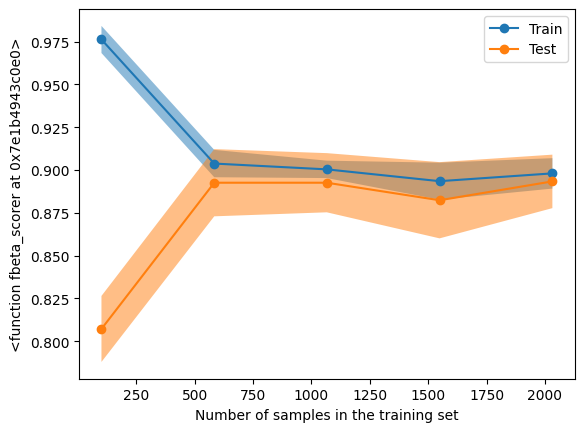

In [38]:
# LEARNING CURVE
common_params = {
    "X": train_x,
    "y": train_y,
    "train_sizes": np.linspace(0.05, 1.0, 5),
    "cv": CV,
    "score_type": "both",
    "n_jobs": N_JOBS,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": SCORER,
}
LearningCurveDisplay.from_estimator(create_pipeline(gs.best_params_), **common_params)

In [39]:
# EVAL
preds = cross_val_predict(
    create_pipeline(gs.best_params_),
    train_x,
    train_y,
    cv=CV,
    n_jobs=N_JOBS
)
print(len(preds))
print(classification_report(train_y, preds))
print("fbeta", fbeta_score(train_y, preds, beta=2))

2541
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1552
           1       0.85      0.90      0.87       989

    accuracy                           0.90      2541
   macro avg       0.89      0.90      0.89      2541
weighted avg       0.90      0.90      0.90      2541

fbeta 0.8854687187687388


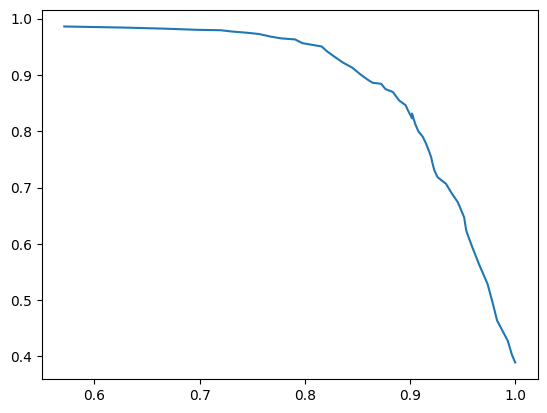

    threshold  recall  precision     f1  fbeta
23       0.46   0.902      0.831  0.865  0.887
25       0.50   0.896      0.846  0.870  0.885
24       0.48   0.898      0.838  0.867  0.885
22       0.44   0.902      0.823  0.861  0.885
21       0.42   0.905      0.813  0.856  0.885
19       0.38   0.912      0.791  0.847  0.885
18       0.36   0.915      0.779  0.841  0.884
20       0.40   0.908      0.800  0.850  0.884
17       0.34   0.917      0.769  0.837  0.883
26       0.52   0.890      0.854  0.872  0.882
16       0.32   0.920      0.754  0.829  0.881
27       0.54   0.884      0.870  0.877  0.881
15       0.30   0.921      0.745  0.824  0.880
12       0.24   0.934      0.706  0.805  0.878
14       0.28   0.923      0.730  0.816  0.877
28       0.56   0.877      0.875  0.876  0.876
11       0.22   0.939      0.691  0.796  0.876
13       0.26   0.926      0.718  0.809  0.876
10       0.20   0.945      0.674  0.787  0.875
29       0.58   0.873      0.884  0.878  0.875
9        0.18

In [40]:
# THRESHOLD TUNING
if tune_threshold:
    preds = cross_val_predict(
        create_pipeline(gs.best_params_),
        train_x,
        train_y,
        cv=CV,
        method="predict_proba",
        n_jobs=N_JOBS
    )

    pr = []
    for T in np.arange(0, 1, 0.02):
        p = (preds[:,1]>T).astype("int")
        precision = precision_score(train_y, p)
        recall = recall_score(train_y, p)
        f1 = f1_score(train_y, p)
        fbeta = fbeta_score(train_y, p, beta=2)
        pr.append((T, recall, precision, f1, fbeta))
    pr = pd.DataFrame(data=pr, columns=["threshold", "recall", "precision", "f1", "fbeta"])
    pr = pr.sort_values(by="recall")
    plt.plot(pr["recall"], pr["precision"])
    plt.show()
    pr = pr.sort_values(by=["fbeta", "recall"], ascending=False)
    print(pr.round(3))
else:
    print("threshold tuning skipped")

In [41]:
# OPTIMAL THRESHOLD
if tune_threshold:
    T = pr.head(1)["threshold"].values[0]
    print(T)
    preds = cross_val_predict(
        create_pipeline(gs.best_params_),
        train_x,    
        train_y,
        cv=CV,
        method="predict_proba",
        n_jobs=N_JOBS
    )
    preds = (preds[:,1]>T).astype("int")
    print(classification_report(train_y, preds))
    print("fbeta", fbeta_score(train_y, preds, beta=2))
else:
    print("threshold tunning skipped")

0.46
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1552
           1       0.83      0.90      0.87       989

    accuracy                           0.89      2541
   macro avg       0.88      0.89      0.89      2541
weighted avg       0.89      0.89      0.89      2541

fbeta 0.8868562338437065


In [42]:
# BUILD MODEL
clf = create_pipeline(gs.best_params_)
clf = clf.fit(train_x, train_y)

In [43]:
# TEST EVAL
# print(pd.DataFrame(test_y).value_counts())

# if tune_threshold:
#     preds = clf.predict_proba(test_x)
#     preds = (preds[:,1]>T).astype("int")
# else:
#     preds = clf.predict(test_x)
# print(classification_report(test_y, preds))
# fbeta = fbeta_score(test_y, preds, beta=2)
# print("fbeta", fbeta)